# Pytorch Convolutional Neural Network

<img src='https://miro.medium.com/max/3288/1*uAeANQIOQPqWZnnuH-VEyw.jpeg'   width="700" height="350">

##### Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
import pandas as pd
from time import time
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
from sklearn.preprocessing import LabelEncoder
import os
os.chdir('f:/exterior')

##### Loading all file names

In [2]:
files = glob('*.jpg')
files = np.random.permutation(files)

In [3]:
files[:5]

array(['smart_fortwo_2013_17_15_700_10_3_61_60_106_34_RWD_2_2_Convertible_zHI.jpg',
       'Honda_Ridgeline_2008_28_17_240_35_6_76_70_206_15_4WD_5_4_Pickup_Ttk.jpg',
       'Audi_A7_2012_59_18_310_30_6_75_55_195_18_AWD_4_4_4dr_naU.jpg',
       'Kia_Sedona_2017_33_18_270_33_6_78_69_201_18_FWD_8_4_Van_CVX.jpg',
       'Volvo_V60_2016_37_17_250_25_5_73_58_182_20_AWD_5_4_4dr_nok.jpg'],
      dtype='<U88')

##### Keeping only Audi/BMW

In [4]:
cars = [i for i in files if i.split('_')[0] in ('Audi', 'BMW')]

In [5]:
cars[:5]

['Audi_A7_2012_59_18_310_30_6_75_55_195_18_AWD_4_4_4dr_naU.jpg',
 'BMW_2-Series_2020_41_17_240_20_4_69_55_174_23_RWD_4_2_Convertible_DfX.jpg',
 'Audi_A4_2019_37_17_180_20_4_72_56_186_27_FWD_5_4_4dr_CyR.jpg',
 'BMW_X5_2017_56_19_300_30_6_76_69_192_18_RWD_5_4_SUV_eXs.jpg',
 'Audi_Q8_2019_67_20_330_30_6_78_67_196_17_AWD_5_4_SUV_MmZ.jpg']

In [6]:
audi = [i for i in cars if i.split('_')[0] == 'Audi']
bmw = [i for i in cars if i.split('_')[0] == 'BMW']

In [7]:
print(f'There are {len(audi)} Audis and {len(bmw)} BMWs.')

There are 3131 Audis and 4121 BMWs.


In [8]:
n_each = np.minimum(len(audi), len(bmw))//1000*1000

In [9]:
cars = np.random.choice(audi, n_each, replace=False).tolist() +\
       np.random.choice(bmw, n_each, replace=False).tolist()

In [10]:
makes = np.repeat('Audi', n_each).tolist() + np.repeat('BMW', n_each).tolist()

In [11]:
cat = ['Audi', 'BMW']

In [12]:
assert len(makes) == len(cars), 'The X and Y are not of the same length!'

In [13]:
print('Total length is {:,} cars.'.format(len(cars)))

Total length is 6,000 cars.


##### Cropping function

In [14]:
def crop(filename, w, h):
    image = Image.open(filename)
    width = image.size[0]
    height = image.size[1]

    aspect = width / float(height)

    ideal_width = w
    ideal_height = h

    ideal_aspect = ideal_width / float(ideal_height)

    if aspect > ideal_aspect:
        new_width = int(ideal_aspect * height)
        offset = (width - new_width) / 2
        resize = (offset, 0, width - offset, height)
    else:
        new_height = int(width / ideal_aspect)
        offset = (height - new_height) / 2
        resize = (0, offset, width, height - offset)

    img = image.crop(resize).resize((ideal_width, ideal_height), Image.ANTIALIAS)

    return np.array(img)

##### Loading and cropping images

In [15]:
print('Scaling...')
start = time()
x = []
num_to_load = len(cars)
for ix, file in enumerate(cars[:num_to_load], 1):
    image = crop(file, 75, 45)
    x.append(image)
    if ix % (num_to_load // 10) == 0:
        print(f'{ix/len(cars):.2%} elapsed.')
print(f'\rDone. {int(time() - start)} seconds')
makes = makes[:num_to_load]

Scaling...
10.00% elapsed.
20.00% elapsed.
30.00% elapsed.
40.00% elapsed.
50.00% elapsed.
60.00% elapsed.
70.00% elapsed.
80.00% elapsed.
90.00% elapsed.
100.00% elapsed.
Done. 49 seconds


##### Turning the pictures into arrays

In [16]:
le = LabelEncoder()
y = le.fit_transform(makes)

In [17]:
x = np.array(x, dtype=np.float32)
y = np.array(y, dtype=np.float32)

In [18]:
n, h, w, c = x.shape
print(x.shape)

(6000, 45, 75, 3)


In [19]:
if x.shape[0] == y.shape[0]:
    print('X and Y shapes are correct! (%i samples each)' % x.shape[0])

X and Y shapes are correct! (6000 samples each)


In [20]:
yy, xx = y.nbytes, x.nbytes

In [21]:
print(f'The size of X is {xx/1e9:,.2f} GB and the size of Y is {yy/1e6:,.4f} MB.')

The size of X is 0.24 GB and the size of Y is 0.0240 MB.


In [22]:
print(f'The size of the data we are using is {x.shape[0]:,} pictures.')

The size of the data we are using is 6,000 pictures.


In [23]:
# files, cars = None, None

##### Displaying the pictures

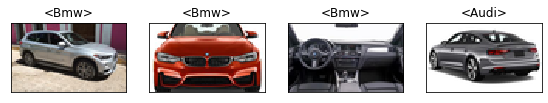

In [24]:
np.random.seed(45)
fig = plt.figure(figsize=(12, 12))
for i in range(1, 5):
    rand = np.random.randint(x.shape[0])
    plt.subplot(1, 5, i)
    ax = plt.imshow(x[rand].astype(np.uint8), cmap='gray')
    plt.title('<{}>'.format(cat[int(y[rand])].capitalize()))
    yticks = plt.xticks([])
    yticks = plt.yticks([])

##### Cross-validation

In [25]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=2e-1, 
                                                    shuffle=True)

In [26]:
trainsize, testsize = x_train.shape[0], x_test.shape[0]
print(f'The size of the training set is {trainsize:,} and the '\
     f'size of the test set is {testsize:,}.')

The size of the training set is 4,800 and the size of the test set is 1,200.


##### Scaling, casting the arrays

In [27]:
print('Scaling...', end='')
x_train = x_train.reshape(-1, 3, h, w).astype('float32') / 255 
x_test = x_test.reshape(-1, 3, h, w).astype('float32') / 255
y_train = y_train.astype('int64')
y_test = y_test.astype('int64')
print('\rDone.     ')

Done.     


In [28]:
samples, first, second, third = x_train.shape
print('First dimension: %i' % samples,
     '\nSecond dimension: %i' % first,
     '\nThird dimension: %i' % second,
     '\nFourth dimension: %i' % third)

First dimension: 4800 
Second dimension: 3 
Third dimension: 45 
Fourth dimension: 75


##### Sending the arrays to Cuda

In [29]:
if torch.cuda.is_available():
    x_train = torch.from_numpy(x_train) 
    x_test = torch.from_numpy(x_test) 
    y_train = torch.from_numpy(y_train) 
    y_test = torch.from_numpy(y_test)
    print('Tensors successfully flushed to CUDA.')
else:
    print('CUDA not available!')

Tensors successfully flushed to CUDA.


##### Clearning memory

In [30]:
# x, y = None, None

##### Building the ConvNet

Initially image size, W = 60 <br>
Kernel Size, k = 3 <br>
Stride , s = 1 <br>
Padding, P = 0 <br>
The formula for the number of outputs to the next layer of conv2d is: O = { (W - k + 2*P)/s } + 1

In [31]:
class ConvNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        a = 64 
        b = 128 
        c = 256 
        
        d = 1024
        e = 2048
        
        self.conv1 = nn.Conv2d(3, a, 3)
        self.conv2 = nn.Conv2d(a, b, 3)
        self.conv3 = nn.Conv2d(b, c, 3)
        
        self.fc1 = nn.Linear(3*7*c, d) 
        self.fc2 = nn.Linear(d, e)
        self.fc3 = nn.Linear(e, 2)
    
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.dropout(x, 0.5)
        x = self.fc3(x)
        return x

In [32]:
net = ConvNet()

In [33]:
if torch.cuda.is_available():
    net.cuda()

In [34]:
print(net)

ConvNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=5376, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=2048, bias=True)
  (fc3): Linear(in_features=2048, out_features=2, bias=True)
)


In [35]:
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [36]:
loss_function = nn.CrossEntropyLoss()

##### Instantiating the data

In [37]:
class CarTrain():
    
    def __init__(self):
        self.len = x_train.shape[0]
        self.x_train = x_train
        self.y_train = y_train
        
    def __getitem__(self, index):
        return x_train[index], y_train[index] 
    
    def __len__(self):
        return self.len

In [38]:
class CarTest():
    
    def __init__(self):
        self.len = x_test.shape[0]
        self.x_test = x_test
        self.y_test = y_test
        
    def __getitem__(self, index):
        return x_test[index], y_test[index] 
    
    def __len__(self):
        return self.len

##### Making instances of the data

In [39]:
train = CarTrain()
test = CarTest()

##### Making data iterator

In [40]:
train_loader = DataLoader(dataset=train, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test, batch_size=64, shuffle=True)

##### Training the model

In [41]:
epochs = 100
steps = 0
train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    net.train()
    for images, labels in train_loader:   
        if torch.cuda.is_available():
            images, labels = images.cuda(), labels.cuda()     
        optimizer.zero_grad()
        log_ps = net(images)
        loss = loss_function(log_ps, labels)
        loss.backward()
        optimizer.step()        
        running_loss += loss.item()        
    else:
        test_loss = 0
        accuracy = 0        
        net.eval()
        with torch.no_grad():
            for images, labels in test_loader:
                if torch.cuda.is_available():
                    images, labels = images.cuda(), labels.cuda()
                log_ps = net(images)
                test_loss += loss_function(log_ps, labels)                
                # ps = torch.exp(log_ps)
                top_p, top_class = log_ps.topk(1, dim=1)
                equals = top_class.long() == labels.long().view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))                
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))
        print("[Epoch: {}/{}] ".format(e+1, epochs),
              "[Training Loss: {:.3f}] ".format(running_loss/len(train_loader)),
              "[Test Loss: {:.3f}] ".format(test_loss/len(test_loader)),
              "[Test Accuracy: {:.3f}]".format(accuracy/len(test_loader)))

[Epoch: 1/100]  [Training Loss: 0.705]  [Test Loss: 0.692]  [Test Accuracy: 0.503]
[Epoch: 2/100]  [Training Loss: 0.694]  [Test Loss: 0.693]  [Test Accuracy: 0.510]
[Epoch: 3/100]  [Training Loss: 0.693]  [Test Loss: 0.693]  [Test Accuracy: 0.508]
[Epoch: 4/100]  [Training Loss: 0.693]  [Test Loss: 0.693]  [Test Accuracy: 0.486]
[Epoch: 5/100]  [Training Loss: 0.693]  [Test Loss: 0.694]  [Test Accuracy: 0.502]
[Epoch: 6/100]  [Training Loss: 0.694]  [Test Loss: 0.693]  [Test Accuracy: 0.492]
[Epoch: 7/100]  [Training Loss: 0.693]  [Test Loss: 0.693]  [Test Accuracy: 0.516]
[Epoch: 8/100]  [Training Loss: 0.692]  [Test Loss: 0.693]  [Test Accuracy: 0.508]
[Epoch: 9/100]  [Training Loss: 0.688]  [Test Loss: 0.690]  [Test Accuracy: 0.524]
[Epoch: 10/100]  [Training Loss: 0.691]  [Test Loss: 0.693]  [Test Accuracy: 0.509]
[Epoch: 11/100]  [Training Loss: 0.688]  [Test Loss: 0.690]  [Test Accuracy: 0.508]
[Epoch: 12/100]  [Training Loss: 0.688]  [Test Loss: 0.690]  [Test Accuracy: 0.517]
[

[Epoch: 99/100]  [Training Loss: 0.000]  [Test Loss: 3.828]  [Test Accuracy: 0.732]
[Epoch: 100/100]  [Training Loss: 0.000]  [Test Loss: 3.877]  [Test Accuracy: 0.735]
